In [1]:
import sys, os, glob
root_dir = '/home/gddaslab/mxp140/tcr_project_ultimate'
sys.path.append(root_dir)

import h5py
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pdf import pdf, generate_configuration_per_tcr, ci_pdf, plot_pdf

In [3]:
full_data = pd.read_csv(f'{root_dir}/data/BrMET_and_GBM_data-PANPEP.csv', sep=',')
patients = np.unique(full_data['Patient'].values)
# patient_id = 'BrMET009'
for patient_id in patients[:]:
    with h5py.File(f'{root_dir}/results/probabilities/PANPEP/probs_{patient_id}.h5', 'r') as f:
        probs = f['result'][:]
        print(f.keys())
        # print(f'{patient_id}:{probs.shape}')
    size=1000
    all_configs = generate_configuration_per_tcr(probs, sample_size=size)
    patient_data = full_data[full_data["Patient"]==patient_id]
    clone_count_values = patient_data['counts'].values
    n = len(clone_count_values)
    fig, ax = plot_pdf(clone_count_values)
    least_number_of_observations = 10
    ci_df = ci_pdf(all_configs, least_number_of_observations=least_number_of_observations)
    ci_df = ci_df[(ci_df['lower']!=ci_df['median']) &  (ci_df['median']!=ci_df['upper'])]
    ax.fill_between(ci_df['clone_size'], ci_df['lower'], ci_df['upper'], color='red', alpha=0.3, label='model')
    ax.set_title(f'{patient_id}', fontsize=24)
    ax.legend(loc='best', fontsize=24)
    ax.set_xlabel(r"Clone sizes ($M$)", fontsize=20)
    ax.set_ylabel('Probability ($P$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=14, length=6, width=2)
    ax.tick_params(axis='both', which='minor', labelsize=12, length=4, width=1)
    plt.show()

<KeysViewHDF5 ['result']>


AssertionError: max_clone_size (None) must equal min_clone_size (1) + prob_array.shape[1] (10000)

In [3]:
all_configs_flattened = np.concatenate(all_configs)

In [2]:
from scipy.stats import chisquare

In [7]:
max_clone_size_to_consider = 9
f_obs = [np.sum(clone_count_values == i) for i in range(1, max_clone_size_to_consider+1)] + [np.sum(clone_count_values > max_clone_size_to_consider)]
f_exp = [np.mean([np.sum(all_configs[:, j]==i) for j in range(all_configs.shape[1])]) for i in range(1, max_clone_size_to_consider+1)] + [np.mean([np.sum(all_configs[:, j]>max_clone_size_to_consider) for j in range(all_configs.shape[1])])]
print(f'f_obs={f_obs}')
print(f'f_exp={f_exp}')
print(f'chi2-pvalue:{chisquare(f_obs=f_obs, f_exp=f_exp, ddof=0).pvalue}')

f_obs=[np.int64(628), np.int64(132), np.int64(38), np.int64(20), np.int64(14), np.int64(5), np.int64(6), np.int64(1), np.int64(2), np.int64(17)]
f_exp=[np.float64(605.339), np.float64(134.646), np.float64(50.67), np.float64(24.693), np.float64(13.638), np.float64(8.478), np.float64(5.494), np.float64(3.809), np.float64(2.788), np.float64(13.445)]
chi2-pvalue:0.37720828594286615


KeyboardInterrupt: 

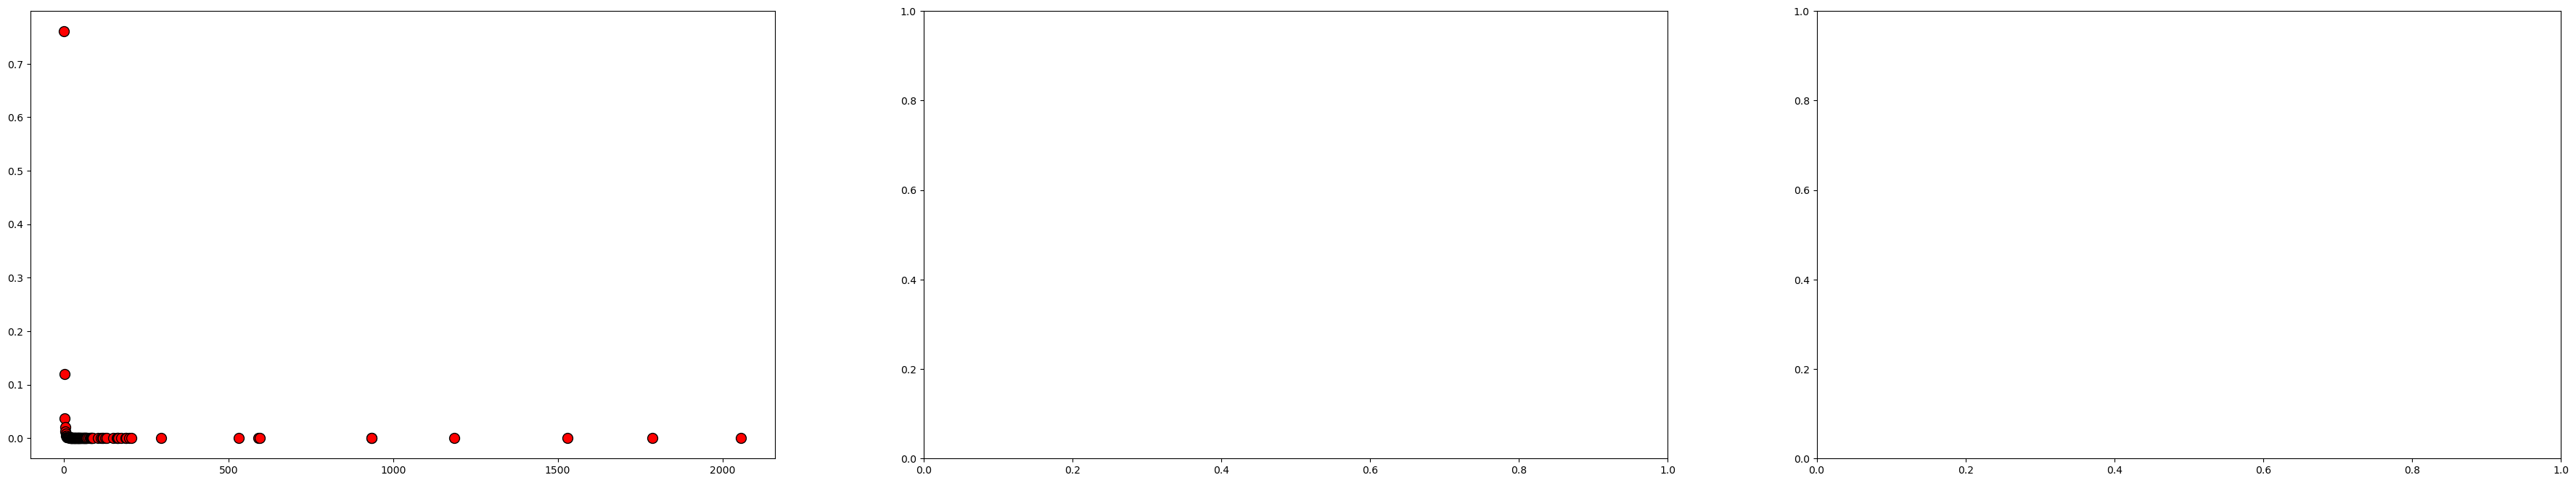

In [3]:
full_data = pd.read_csv(f'{root_dir}/data/BrMET_and_GBM_data-PANPEP.csv', sep=',')
patients = np.unique(full_data['Patient'].values)
size=1000
color_dict = {'BrMET':'red', 'GBM':'blue'}
for patient_id in ['BrMET009', 'GBM059'][:]:#patients[:]:
    data_dir = "/home/gddaslab/mxp140/tcr_project_ultimate/data/glioblastoma_data/PANPEP/"
    filepaths = os.path.join(data_dir, patient_id, f"{patient_id}_region*.csv")
    files = glob.glob(filepaths)
    sorted_files = sorted(files, key=lambda x: int(x.split("region")[1].split(".")[0]))
    # print(sorted_files)
    region_labels = [f'region{file.split("region")[1].split("_")[0][:-4]}' for file in sorted_files]
    # print(region_labels)
    data = []
    colors = ["blue", "orange", "green", "red"]

    for file in sorted_files:
        df = pd.read_csv(file, sep=",",)
        data.append(df)

    fig, axes = plt.subplots(
        nrows=1, 
        ncols=len(data),
        figsize=(15*len(data), 8),
    )

    for i, (regional_data, ax) in enumerate(zip(data, axes)):
        if regional_data.empty:
            continue
        clone_count_values = list(regional_data['counts'])
        n = len(clone_count_values)
        x_regional, y_regional = pdf(clone_count_values)
        ax.scatter(
            x_regional,
            y_regional,
            s=100,
            facecolors=color_dict.get('GBM' if 'GBM' in patient_id else 'BrMET'),
            edgecolors="black",
            zorder=1,
            label='data',
            alpha=1
        )
        with h5py.File(f'{root_dir}/results/probabilities/PANPEP/probs_{patient_id}_{region_labels[i]}.h5', 'r') as f:
            probs = f['result'][:]
            # print(probs.shape)
        all_configs = generate_configuration_per_tcr(probs, size)
        # print(all_configs.shape)
        least_number_of_observations = 10
        ci_df = ci_pdf(all_configs, least_number_of_observations=least_number_of_observations)
        ci_df = ci_df[(ci_df['lower']!=ci_df['median']) &  (ci_df['median']!=ci_df['upper'])]
        ax.fill_between(ci_df['clone_size'], ci_df['lower'], ci_df['upper'], color=color_dict.get('GBM' if 'GBM' in patient_id else 'BrMET'), alpha=0.5, label='model', zorder=-1)
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend(loc="best", fontsize=24)
        ax.set_title(f"{patient_id}-{region_labels[i]}", fontsize=24)
        ax.set_xlabel(r"Clone sizes ($M$)", fontsize=20, fontweight='bold')
        ax.set_ylabel('Probability ($P$)', fontsize=20, fontweight='bold')
        
        # Enhanced tick parameters
        ax.tick_params(axis='both', which='major', labelsize=16, length=8, width=3)
        ax.tick_params(axis='both', which='minor', labelsize=14, length=5, width=2)
        
        # Make axis lines thicker
        for spine in ax.spines.values():
            spine.set_linewidth(3)
        
        # Make tick labels bold by setting font properties
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontweight('bold')

    plt.tight_layout()
    plt.show()

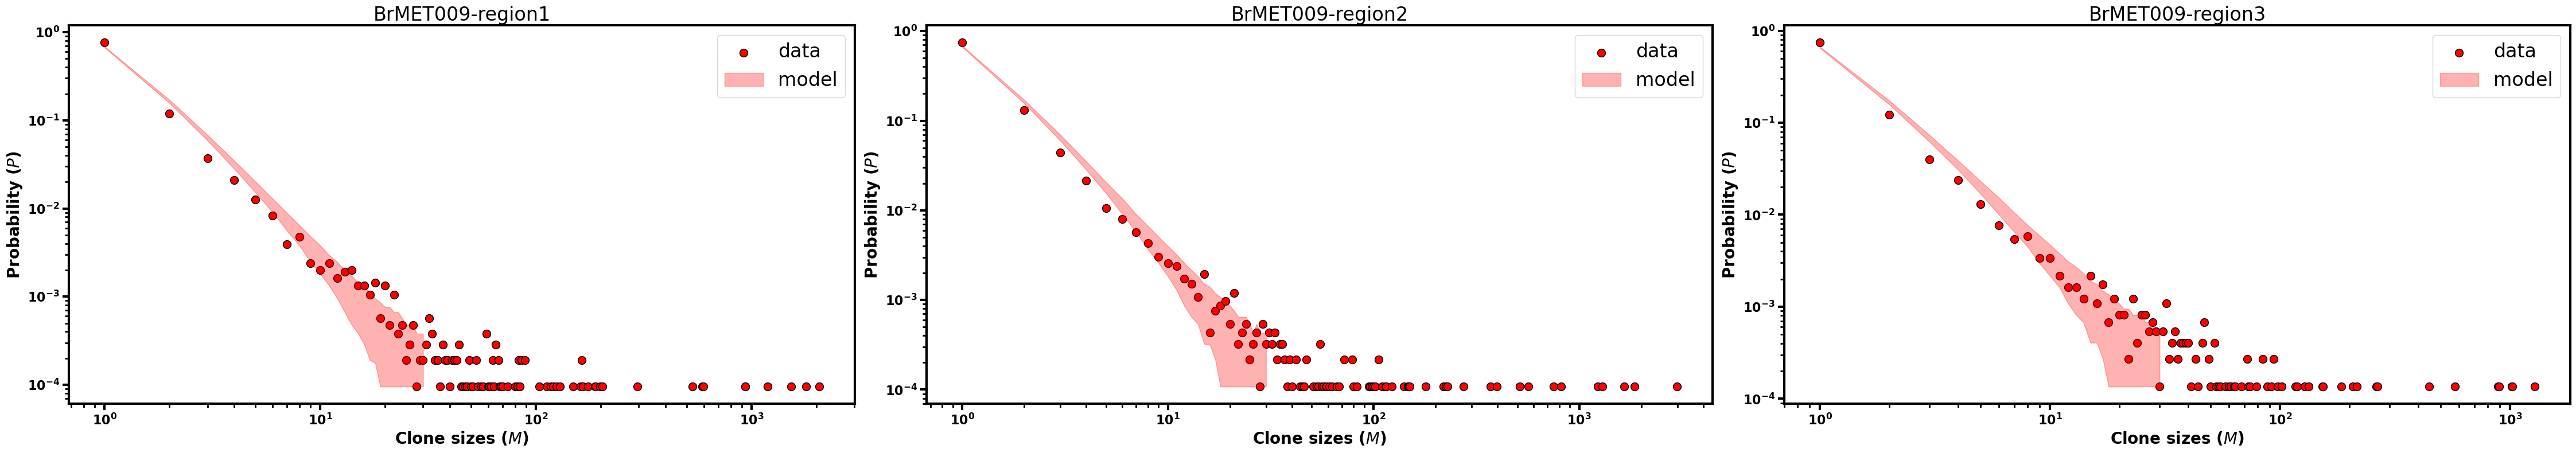

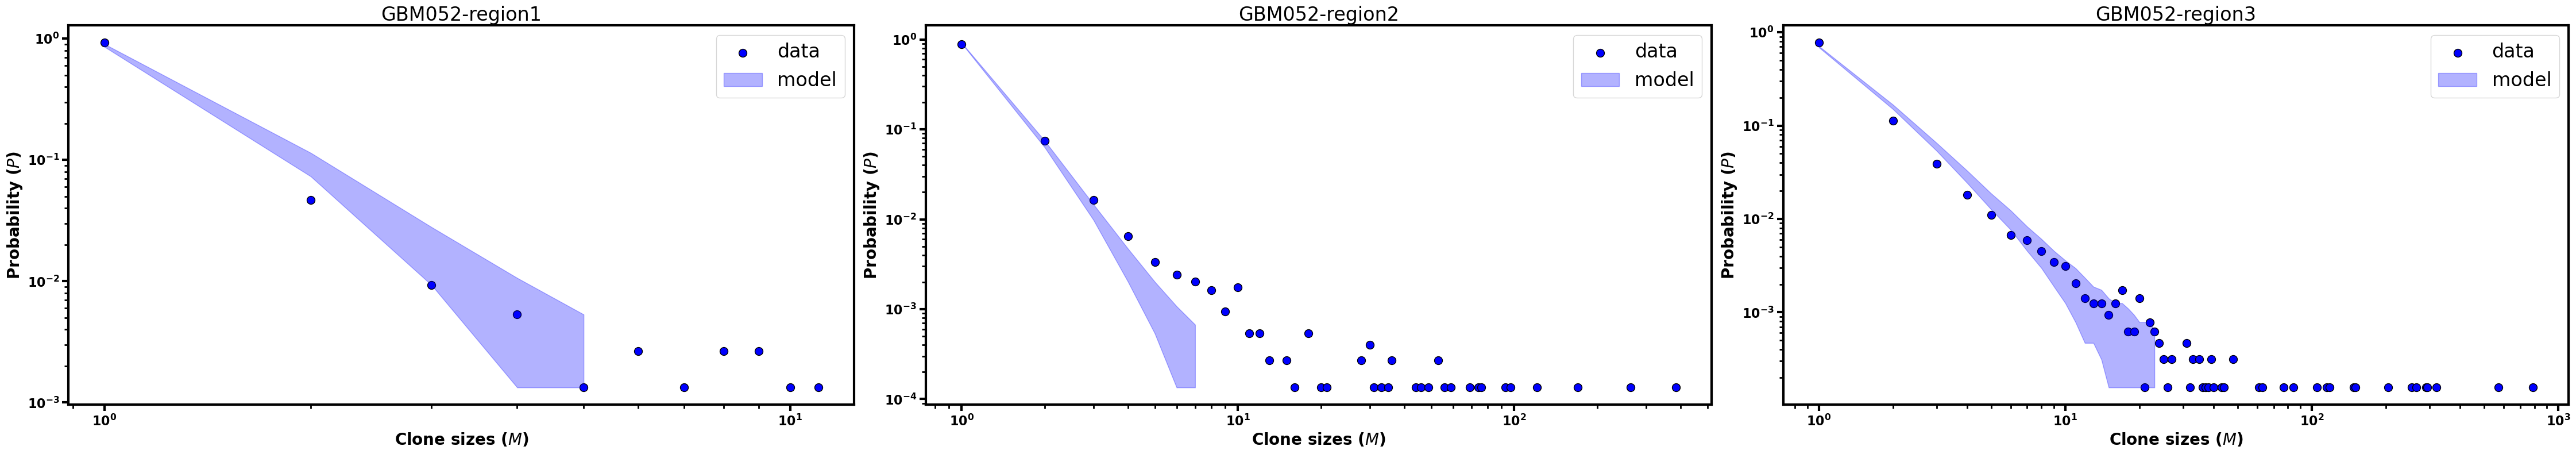

In [9]:
full_data = pd.read_csv(f'{root_dir}/data/BrMET_and_GBM_data-ERGOII.csv', sep=',')
patients = np.unique(full_data['Patient'].values)
size=1000
color_dict = {'BrMET':'red', 'GBM':'blue'}
for patient_id in ['BrMET009', 'GBM052'][:]:#patients[:]:
    data_dir = "/home/gddaslab/mxp140/tcr_project_ultimate/data/glioblastoma_data/ERGOII/"
    filepaths = os.path.join(data_dir, patient_id, f"{patient_id}_region*.csv")
    files = glob.glob(filepaths)
    sorted_files = sorted(files, key=lambda x: int(x.split("region")[1].split(".")[0]))
    # print(sorted_files)
    region_labels = [f'region{file.split("region")[1].split("_")[0][:-4]}' for file in sorted_files]
    # print(region_labels)
    data = []
    colors = ["blue", "orange", "green", "red"]

    for file in sorted_files:
        df = pd.read_csv(file, sep=",",)
        data.append(df)

    fig, axes = plt.subplots(
        nrows=1, 
        ncols=len(data),
        figsize=(15*len(data), 8),
    )

    for i, (regional_data, ax) in enumerate(zip(data, axes)):
        if regional_data.empty:
            continue
        clone_count_values = list(regional_data['counts'])
        n = len(clone_count_values)
        x_regional, y_regional = pdf(clone_count_values)
        ax.scatter(
            x_regional,
            y_regional,
            s=100,
            facecolors=color_dict.get('GBM' if 'GBM' in patient_id else 'BrMET'),
            edgecolors="black",
            zorder=1,
            label='data',
            alpha=1
        )
        with h5py.File(f'{root_dir}/results/probabilities/VDJDB/probs_{patient_id}_{region_labels[i]}.h5', 'r') as f:
            probs = f['result'][:]
            # print(probs.shape)
        all_configs = generate_configuration_per_tcr(probs, size)
        # print(all_configs.shape)
        least_number_of_observations = 10
        ci_df = ci_pdf(all_configs, least_number_of_observations=least_number_of_observations)
        ci_df = ci_df[(ci_df['lower']!=ci_df['median']) &  (ci_df['median']!=ci_df['upper'])]
        ax.fill_between(ci_df['clone_size'], ci_df['lower'], ci_df['upper'], color=color_dict.get('GBM' if 'GBM' in patient_id else 'BrMET'), alpha=0.3, label='model')
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend(loc="best", fontsize=24)
        ax.set_title(f"{patient_id}-{region_labels[i]}", fontsize=24)
        ax.set_xlabel(r"Clone sizes ($M$)", fontsize=20, fontweight='bold')
        ax.set_ylabel('Probability ($P$)', fontsize=20, fontweight='bold')
        
        # Enhanced tick parameters
        ax.tick_params(axis='both', which='major', labelsize=16, length=8, width=3)
        ax.tick_params(axis='both', which='minor', labelsize=14, length=5, width=2)
        
        # Make axis lines thicker
        for spine in ax.spines.values():
            spine.set_linewidth(3)
        
        # Make tick labels bold by setting font properties
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontweight('bold')

    plt.tight_layout()
    plt.show()

In [39]:
from scipy.stats import pearsonr

1-config: PearsonRResult(statistic=np.float64(0.07184745815361268), pvalue=np.float64(9.254163317544223e-14))
1000-config: PearsonRResult(statistic=np.float64(0.8274361868291602), pvalue=np.float64(0.0))


1-config: PearsonRResult(statistic=np.float64(0.11010325597692072), pvalue=np.float64(7.40927421726916e-27))
1000-config: PearsonRResult(statistic=np.float64(0.8283695550306244), pvalue=np.float64(0.0))


1-config: PearsonRResult(statistic=np.float64(0.030374577736878676), pvalue=np.float64(0.008325725579026829))
1000-config: PearsonRResult(statistic=np.float64(0.7852946420807722), pvalue=np.float64(0.0))


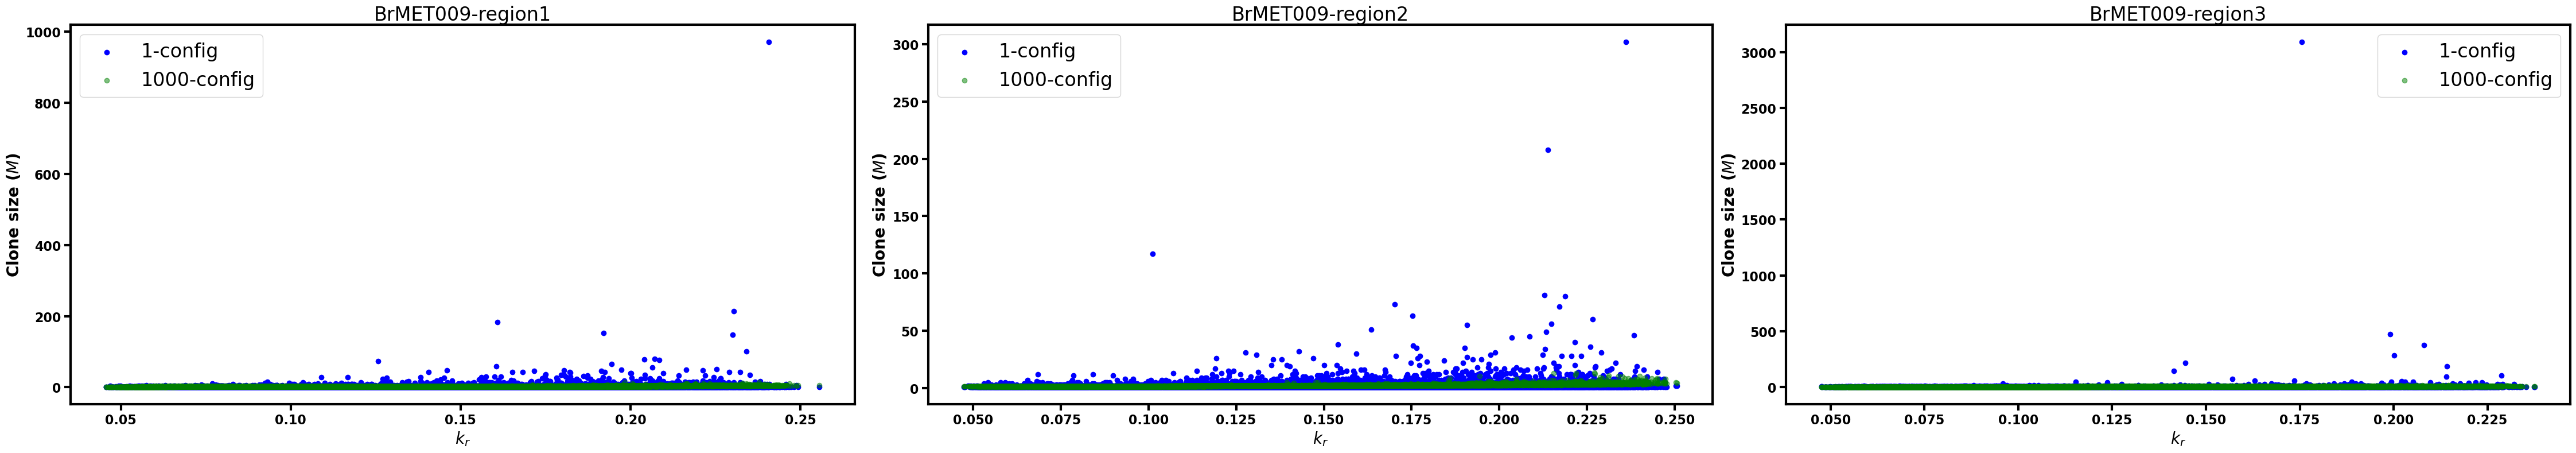

In [40]:
full_data = pd.read_csv(f'{root_dir}/data/BrMET_and_GBM_data-PANPEP.csv', sep=',')
max_kr = np.max(full_data['kr'].values)
patients = np.unique(full_data['Patient'].values)
color_dict = {'BrMET':'red', 'GBM':'blue'}
for patient_id in ['BrMET009', 'GBM052'][:1]:#patients[:]:
    data_dir = "/home/gddaslab/mxp140/tcr_project_ultimate/data/glioblastoma_data/PANPEP/"
    filepaths = os.path.join(data_dir, patient_id, f"{patient_id}_region*.csv")
    files = glob.glob(filepaths)
    sorted_files = sorted(files, key=lambda x: int(x.split("region")[1].split(".")[0]))
    # print(sorted_files)
    region_labels = [f'region{file.split("region")[1].split("_")[0][:-4]}' for file in sorted_files]
    # print(region_labels)
    data = []
    colors = ["blue", "orange", "green", "red"]

    for file in sorted_files:
        df = pd.read_csv(file, sep=",",)
        data.append(df)

    fig, axes = plt.subplots(
        nrows=1, 
        ncols=len(data),
        figsize=(15*len(data), 8),
    )

    for i, (regional_data, ax) in enumerate(zip(data, axes)):
        if regional_data.empty:
            continue
        with h5py.File(f'{root_dir}/results/probabilities/PANPEP/probs_{patient_id}_{region_labels[i]}.h5', 'r') as f:
            probs = f['result'][:]
            # print(probs.shape)
        all_configs = generate_configuration_per_tcr(probs, size=1)
        all_configs2 = generate_configuration_per_tcr(probs, size=1000)
        ax.scatter(regional_data['kr'].values/max_kr, all_configs[:, 0], color='blue', alpha=1.0, label='1-config')
        ax.scatter(regional_data['kr'].values/max_kr, all_configs2.mean(axis=1), color='green', alpha=0.5, label='1000-config')
        print(f'1-config: {pearsonr(regional_data['kr'].values/max_kr, all_configs[:, 0])}')
        print(f'1000-config: {pearsonr(regional_data['kr'].values/max_kr, all_configs2.mean(axis=1))}')
        
        # ax.set_xscale('log')
        # ax.set_yscale('log')
        ax.legend(loc="best", fontsize=24)
        ax.set_title(f"{patient_id}-{region_labels[i]}", fontsize=24)
        ax.set_ylabel(r"Clone size ($M$)", fontsize=20, fontweight='bold')
        ax.set_xlabel(r'$k_r$', fontsize=20, fontweight='bold')
        
        # Enhanced tick parameters
        ax.tick_params(axis='both', which='major', labelsize=16, length=8, width=3)
        ax.tick_params(axis='both', which='minor', labelsize=14, length=5, width=2)
        
        # Make axis lines thicker
        for spine in ax.spines.values():
            spine.set_linewidth(3)
        
        # Make tick labels bold by setting font properties
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontweight('bold')

    plt.tight_layout()
    plt.show()

1-config: PearsonRResult(statistic=np.float64(0.12452907858451498), pvalue=np.float64(0.0005333595538201992))
1000-config: PearsonRResult(statistic=np.float64(0.9602818235865528), pvalue=np.float64(0.0))


1-config: PearsonRResult(statistic=np.float64(0.15191604383948742), pvalue=np.float64(2.2195368975490413e-40))
1000-config: PearsonRResult(statistic=np.float64(0.9695057096225065), pvalue=np.float64(0.0))


1-config: PearsonRResult(statistic=np.float64(0.10983167252732695), pvalue=np.float64(5.836371567146591e-19))
1000-config: PearsonRResult(statistic=np.float64(0.8675225195190817), pvalue=np.float64(0.0))


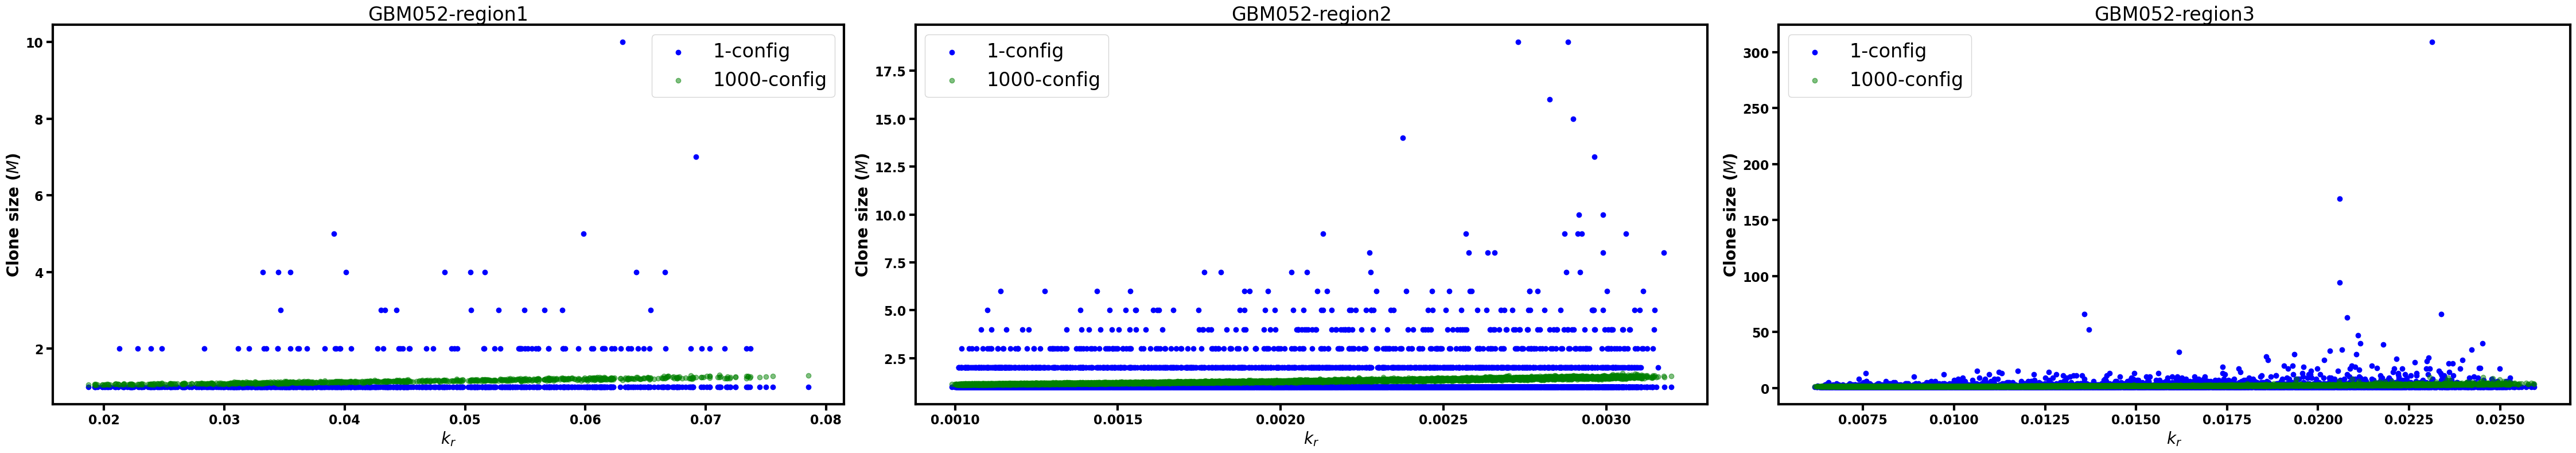

In [41]:
full_data = pd.read_csv(f'{root_dir}/data/BrMET_and_GBM_data-PANPEP.csv', sep=',')
max_kr = np.max(full_data['kr'].values)
patients = np.unique(full_data['Patient'].values)
color_dict = {'BrMET':'red', 'GBM':'blue'}
for patient_id in ['BrMET009', 'GBM052'][-1:]:#patients[:]:
    data_dir = "/home/gddaslab/mxp140/tcr_project_ultimate/data/glioblastoma_data/PANPEP/"
    filepaths = os.path.join(data_dir, patient_id, f"{patient_id}_region*.csv")
    files = glob.glob(filepaths)
    sorted_files = sorted(files, key=lambda x: int(x.split("region")[1].split(".")[0]))
    # print(sorted_files)
    region_labels = [f'region{file.split("region")[1].split("_")[0][:-4]}' for file in sorted_files]
    # print(region_labels)
    data = []
    colors = ["blue", "orange", "green", "red"]

    for file in sorted_files:
        df = pd.read_csv(file, sep=",",)
        data.append(df)

    fig, axes = plt.subplots(
        nrows=1, 
        ncols=len(data),
        figsize=(15*len(data), 8),
    )

    for i, (regional_data, ax) in enumerate(zip(data, axes)):
        if regional_data.empty:
            continue
        with h5py.File(f'{root_dir}/results/probabilities/PANPEP/probs_{patient_id}_{region_labels[i]}.h5', 'r') as f:
            probs = f['result'][:]
            # print(probs.shape)
        all_configs = generate_configuration_per_tcr(probs, size=1)
        all_configs2 = generate_configuration_per_tcr(probs, size=1000)
        ax.scatter(regional_data['kr'].values/max_kr, all_configs[:, 0], color='blue', alpha=1.0, label='1-config')
        ax.scatter(regional_data['kr'].values/max_kr, all_configs2.mean(axis=1), color='green', alpha=0.5, label='1000-config')
        print(f'1-config: {pearsonr(regional_data['kr'].values/max_kr, all_configs[:, 0])}')
        print(f'1000-config: {pearsonr(regional_data['kr'].values/max_kr, all_configs2.mean(axis=1))}')
        
        ax.legend(loc="best", fontsize=24)
        ax.set_title(f"{patient_id}-{region_labels[i]}", fontsize=24)
        ax.set_ylabel(r"Clone size ($M$)", fontsize=20, fontweight='bold')
        ax.set_xlabel(r'$k_r$', fontsize=20, fontweight='bold')
        
        # Enhanced tick parameters
        ax.tick_params(axis='both', which='major', labelsize=16, length=8, width=3)
        ax.tick_params(axis='both', which='minor', labelsize=14, length=5, width=2)
        
        # Make axis lines thicker
        for spine in ax.spines.values():
            spine.set_linewidth(3)
        
        # Make tick labels bold by setting font properties
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontweight('bold')

    plt.tight_layout()
    plt.show()

1-config: PearsonRResult(statistic=np.float64(0.10407895729569741), pvalue=np.float64(3.1136426627263115e-27))
1000-config: PearsonRResult(statistic=np.float64(0.823783885302716), pvalue=np.float64(0.0))


1-config: PearsonRResult(statistic=np.float64(0.09934913905213504), pvalue=np.float64(3.81691554202675e-22))
1000-config: PearsonRResult(statistic=np.float64(0.8199591529332116), pvalue=np.float64(0.0))


1-config: PearsonRResult(statistic=np.float64(0.07283575774674533), pvalue=np.float64(2.388512745134087e-10))
1000-config: PearsonRResult(statistic=np.float64(0.7918315417138192), pvalue=np.float64(0.0))


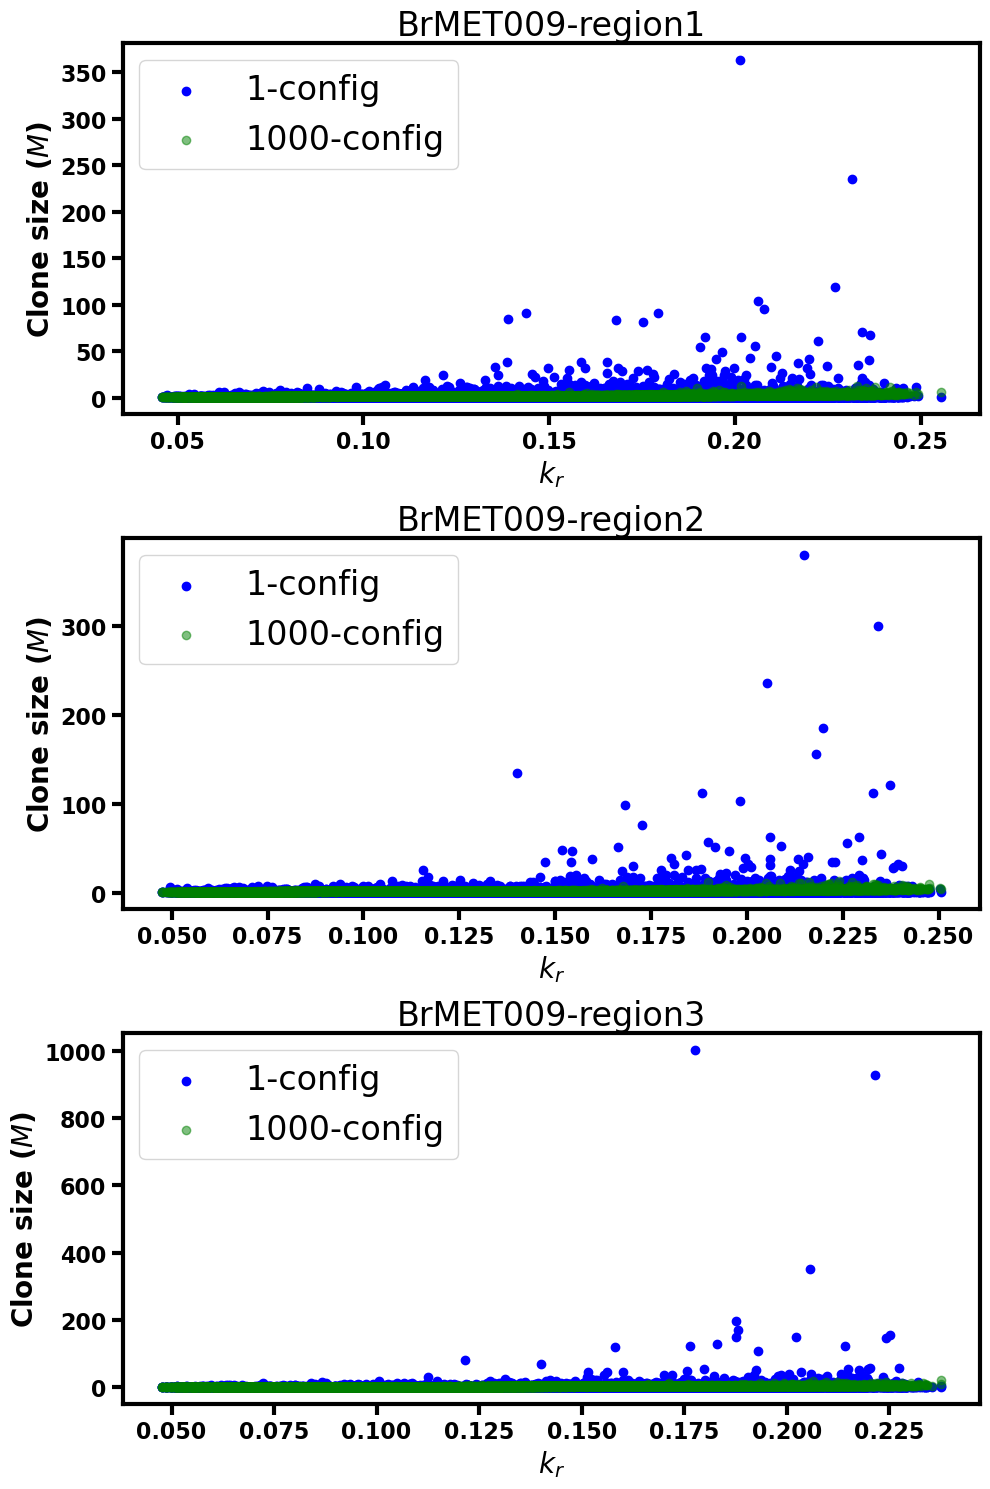

In [44]:
full_data = pd.read_csv(f'{root_dir}/data/BrMET_and_GBM_data-PANPEP.csv', sep=',')
max_kr = np.max(full_data['kr'].values)
patients = np.unique(full_data['Patient'].values)
color_dict = {'BrMET':'red', 'GBM':'blue'}
for patient_id in ['BrMET009', 'GBM052'][:1]:#patients[:]:
    data_dir = "/home/gddaslab/mxp140/tcr_project_ultimate/data/glioblastoma_data/PANPEP/"
    filepaths = os.path.join(data_dir, patient_id, f"{patient_id}_region*.csv")
    files = glob.glob(filepaths)
    sorted_files = sorted(files, key=lambda x: int(x.split("region")[1].split(".")[0]))
    # print(sorted_files)
    region_labels = [f'region{file.split("region")[1].split("_")[0][:-4]}' for file in sorted_files]
    # print(region_labels)
    data = []
    colors = ["blue", "orange", "green", "red"]

    for file in sorted_files:
        df = pd.read_csv(file, sep=",",)
        data.append(df)

    fig, axes = plt.subplots(
        ncols=1, 
        nrows=len(data),
        figsize=(10, 15),
    )

    for i, (regional_data, ax) in enumerate(zip(data, axes)):
        if regional_data.empty:
            continue
        with h5py.File(f'{root_dir}/results/probabilities/PANPEP/probs_{patient_id}_{region_labels[i]}.h5', 'r') as f:
            probs = f['result'][:]
            # print(probs.shape)
        all_configs = generate_configuration_per_tcr(probs, size=1)
        all_configs2 = generate_configuration_per_tcr(probs, size=1000)
        ax.scatter(regional_data['kr'].values/max_kr, all_configs[:, 0], color='blue', alpha=1.0, label='1-config')
        ax.scatter(regional_data['kr'].values/max_kr, all_configs2.mean(axis=1), color='green', alpha=0.5, label='1000-config')
        print(f'1-config: {pearsonr(regional_data['kr'].values/max_kr, all_configs[:, 0])}')
        print(f'1000-config: {pearsonr(regional_data['kr'].values/max_kr, all_configs2.mean(axis=1))}')
        
        # ax.set_xscale('log')
        # ax.set_yscale('log')
        ax.legend(loc="best", fontsize=24)
        ax.set_title(f"{patient_id}-{region_labels[i]}", fontsize=24)
        ax.set_ylabel(r"Clone size ($M$)", fontsize=20, fontweight='bold')
        ax.set_xlabel(r'$k_r$', fontsize=20, fontweight='bold')
        
        # Enhanced tick parameters
        ax.tick_params(axis='both', which='major', labelsize=16, length=8, width=3)
        ax.tick_params(axis='both', which='minor', labelsize=14, length=5, width=2)
        
        # Make axis lines thicker
        for spine in ax.spines.values():
            spine.set_linewidth(3)
        
        # Make tick labels bold by setting font properties
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontweight('bold')

    plt.tight_layout()
    plt.show()